<a href="https://colab.research.google.com/github/mattabott/Breath_cancer_prediction/blob/main/Breath_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Custom CNN on Breath Cancer

In this notebook I use a breath cancer dataset available on kaggle (https://www.kaggle.com/uciml/breast-cancer-wisconsin-data).

The dataset was created by digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

We have 10 characteristics of nuclei:

a) radius (mean of distances from center to points on the perimeter)

b) texture (standard deviation of gray-scale values)

c) perimeter

d) area

e) smoothness (local variation in radius lengths)

f) compactness (perimeter^2 / area - 1.0)

g) concavity (severity of concave portions of the contour)

h) concave points (number of concave portions of the contour)

i) symmetry

j) fractal dimension ("coastline approximation" - 1)

Each feature has 3 different parameters: mean, standard error and worst.

To solve this classification problem I'll use a deep learning CNN with custom architecture.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Test/breast-cancer.csv')

data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
data = data.drop(columns='id')

data['diagnosis'].replace(to_replace='M', value=1, inplace=True)
data['diagnosis'].replace(to_replace='B', value=0, inplace=True)
data['diagnosis'] = data.diagnosis.astype(float)
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Start to order classes by characteristic.

In [ ]:
data = data[[
            'diagnosis', 
            'radius_mean', 
            'radius_se', 
            'radius_worst',
            'texture_mean', 
            'texture_se', 
            'texture_worst',
            'perimeter_mean', 
            'perimeter_se', 
            'perimeter_worst',
            'area_mean', 
            'area_se', 
            'area_worst',
            'smoothness_mean', 
            'smoothness_se', 
            'smoothness_worst',
            'compactness_mean', 
            'compactness_se', 
            'compactness_worst',
            'concavity_mean', 
            'concavity_se', 
            'concavity_worst',
            'concave points_mean',
            'concave points_se', 
            'concave points_worst',
            'symmetry_mean', 
            'symmetry_se', 
            'symmetry_worst',
            'fractal_dimension_mean', 
            'fractal_dimension_se', 
            'fractal_dimension_worst'          
]]

data.head()

,diagnosis,radius_mean,radius_se,radius_worst,texture_mean,texture_se,texture_worst,perimeter_mean,perimeter_se,perimeter_worst,area_mean,area_se,area_worst,smoothness_mean,smoothness_se,smoothness_worst,compactness_mean,compactness_se,compactness_worst,concavity_mean,concavity_se,concavity_worst,concave points_mean,concave points_se,concave points_worst,symmetry_mean,symmetry_se,symmetry_worst,fractal_dimension_mean,fractal_dimension_se,fractal_dimension_worst
0,1.0,17.99,1.0950,25.38,10.38,0.9053,17.33,122.80,8.589,184.60,1001.0,153.40,2019.0,0.11840,0.006399,0.1622,0.27760,0.04904,0.6656,0.3001,0.05373,0.7119,0.14710,0.01587,0.2654,0.2419,0.03003,0.4601,0.07871,0.006193,0.11890
1,1.0,20.57,0.5435,24.99,17.77,0.7339,23.41,132.90,3.398,158.80,1326.0,74.08,1956.0,0.08474,0.005225,0.1238,0.07864,0.01308,0.1866,0.0869,0.01860,0.2416,0.07017,0.01340,0.1860,0.1812,0.01389,0.2750,0.05667,0.003532,0.08902
2,1.0,19.69,0.7456,23.57,21.25,0.7869,25.53,130.00,4.585,152.50,1203.0,94.03,1709.0,0.10960,0.006150,0.1444,0.15990,0.04006,0.4245,0.1974,0.03832,0.4504,0.12790,0.02058,0.2430,0.2069,0.02250,0.3613,0.05999,0.004571,0.08758
3,1.0,11.42,0.4956,14.91,20.38,1.1560,26.50,77.58,3.445,98.87,386.1,27.23,567.7,0.14250,0.009110,0.2098,0.28390,0.07458,0.8663,0.2414,0.05661,0.6869,0.10520,0.01867,0.2575,0.2597,0.05963,0.6638,0.09744,0.009208,0.17300
4,1.0,20.29,0.7572,22.54,14.34,0.7813,16.67,135.10,5.438,152.20,1297.0,94.44,1575.0,0.10030,0.011490,0.1374,0.13280,0.02461,0.2050,0.1980,0.05688,0.4000,0.10430,0.01885,0.1625,0.1809,0.01756,0.2364,0.05883,0.005115,0.07678


In [ ]:
df = data.values

x = df[:, 1:]
y = df[:, :1]

Choose to have different x for each characteristic.
Doing so we could have different input for the model.

In [ ]:
scaler = StandardScaler()

x = scaler.fit_transform(x)

print(x[0])

x_radius = x[:, 0:3]
x_texture = x[:, 3:6]
x_perimeter = x[:, 6:9]
x_area = x[:, 9:12]
x_smoothness = x[:, 12:15]
x_compactness = x[:, 15:18]
x_concavity = x[:, 18:21]
x_concave_points = x[:, 21:24]
x_symmetry = x[:, 24:27]
x_fractal_dim = x[:, 27:30]

print('\n',('- - - // - - - ') *5, '\n')
print(x_radius[0])
print(x_texture[0])
print(x_perimeter[0])
print(x_area[0])
print(x_smoothness[0])
print(x_compactness[0])
print(x_concavity[0])
print(x_concave_points[0])
print(x_symmetry[0])
print(x_fractal_dim[0])

[ 1.09706398  2.48973393  1.88668963 -2.07333501 -0.56526506 -1.35929347
  1.26993369  2.83303087  2.30360062  0.9843749   2.48757756  2.00123749
  1.56846633 -0.21400165  1.30768627  3.28351467  1.31686157  2.61666502
  2.65287398  0.72402616  2.10952635  2.53247522  0.66081994  2.29607613
  2.21751501  1.14875667  2.75062224  2.25574689  0.90708308  1.93701461]

 - - - // - - - - - - // - - - - - - // - - - - - - // - - - - - - // - - -  

[1.09706398 2.48973393 1.88668963]
[-2.07333501 -0.56526506 -1.35929347]
[1.26993369 2.83303087 2.30360062]
[0.9843749  2.48757756 2.00123749]
[ 1.56846633 -0.21400165  1.30768627]
[3.28351467 1.31686157 2.61666502]
[2.65287398 0.72402616 2.10952635]
[2.53247522 0.66081994 2.29607613]
[2.21751501 1.14875667 2.75062224]
[2.25574689 0.90708308 1.93701461]


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(455, 30)
(114, 30)
(455, 1)
(114, 1)


In [ ]:
x_radius_train, x_radius_test, _, _ = train_test_split(x_radius, y, test_size=0.2, random_state=42)
x_texture_train, x_texture_test, _, _ = train_test_split(x_texture, y, test_size=0.2, random_state=42)
x_perimeter_train, x_perimeter_test, _, _ = train_test_split(x_perimeter, y, test_size=0.2, random_state=42)
x_area_train, x_area_test, _, _ = train_test_split(x_area, y, test_size=0.2, random_state=42)
x_smoothness_train, x_smoothness_test, _, _ = train_test_split(x_smoothness, y, test_size=0.2, random_state=42)
x_compactness_train, x_compactness_test, _, _ = train_test_split(x_compactness, y, test_size=0.2, random_state=42)
x_concavity_train, x_concavity_test, _, _ = train_test_split(x_concavity, y, test_size=0.2, random_state=42)
x_concave_points_train, x_concave_points_test, _, _ = train_test_split(x_concave_points, y, test_size=0.2, random_state=42)
x_symmetry_train, x_symmetry_test, _, _ = train_test_split(x_symmetry, y, test_size=0.2, random_state=42)
x_fractal_dim_train, x_fractal_dim_test, _, _ = train_test_split(x_fractal_dim, y, test_size=0.2, random_state=42)

To get the most real result possible, I decided to divide the model input into 10.

10 as the different characteristics of the core. In this way we are going to combine these characteristics through a Dense layer, and the results will then end up in a convolutive layer that will look for patterns among the results.

By feeding the dataset directly to a convolutional layer, we will have found patterns that may have nothing to do with the dataset itself. In this way, however, we will have correlation between the data, and we will be able to compare the results more clearly.

In [ ]:
def input_model():
  input = keras.Input(shape=(3,1))
  x = Dense(16, activation='relu')(input)
  x = Dense(32, activation='relu')(x)
  output = Dense(1, activation='sigmoid')(x)
  mod = keras.Model(input, output)

  return mod

mod_radius = input_model()
mod_texture = input_model()
mod_perimeter = input_model()
mod_area = input_model()
mod_smoothness = input_model()
mod_compactness = input_model()
mod_concavity = input_model()
mod_concave_points = input_model()
mod_symmetry = input_model()
mod_fractal_dim = input_model()

combo = keras.layers.concatenate([
                                  mod_radius.output, 
                                  mod_texture.output, 
                                  mod_perimeter.output,
                                  mod_area.output,
                                  mod_smoothness.output,
                                  mod_compactness.output,
                                  mod_concavity.output,
                                  mod_concave_points.output,
                                  mod_symmetry.output,
                                  mod_fractal_dim.output
                                  ])

x = Conv1D(64, 3, activation='relu', strides=1, padding='valid')(combo)

x = GlobalMaxPooling1D()(x)

out = Dense(1, activation='sigmoid')(x)

model = keras.Model([
                     mod_radius.input, 
                     mod_texture.input, 
                     mod_perimeter.input,
                     mod_area.input,
                     mod_smoothness.input,
                     mod_compactness.input,
                     mod_concavity.input,
                     mod_concave_points.input,
                     mod_symmetry.input,
                     mod_fractal_dim.input
                     ],
                     out)

model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 1)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3, 1)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 3, 1)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 3, 1)]       0           []                               
                                                                                           

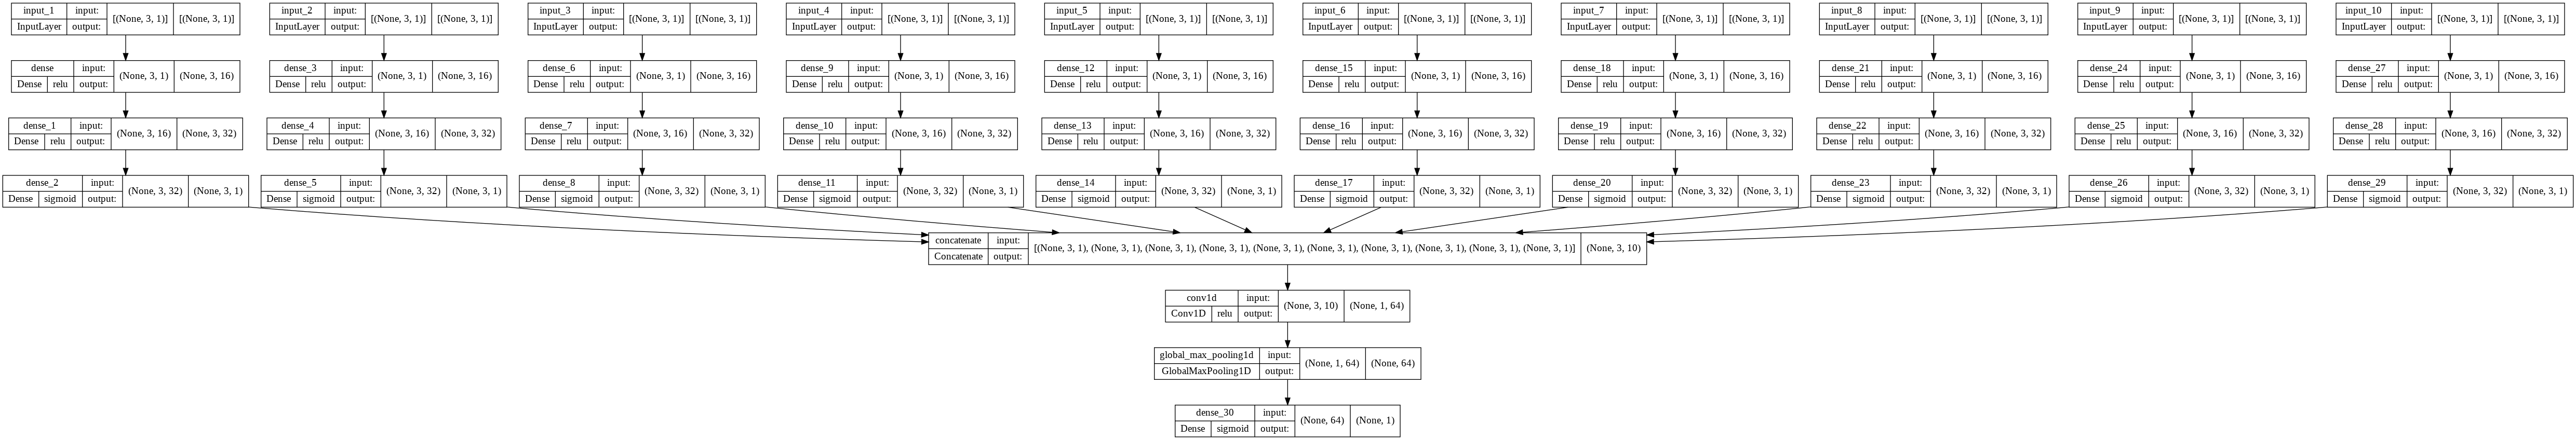

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics='accuracy'
)

In [ ]:
history = model.fit(
   [
    x_radius_train, 
    x_texture_train, 
    x_perimeter_train,
    x_area_train,
    x_smoothness_train,
    x_compactness_train,
    x_concavity_train,
    x_concave_points_train,
    x_symmetry_train,
    x_fractal_dim_train
    ],
   y_train,
   epochs=50,
   batch_size=32,
   validation_data=(
       [
        x_radius_test, 
        x_texture_test, 
        x_perimeter_test,
        x_area_test,
        x_smoothness_test,
        x_compactness_test,
        x_concavity_test,
        x_concave_points_test,
        x_symmetry_test,
        x_fractal_dim_test
        ],
       y_test
       )
)

Epoch 1/50
15/15 [==============================] - 4s 64ms/step - loss: 0.6578 - accuracy: 0.6286 - val_loss: 0.6495 - val_accuracy: 0.6228
Epoch 2/50
15/15 [==============================] - 0s 6ms/step - loss: 0.6323 - accuracy: 0.6286 - val_loss: 0.6161 - val_accuracy: 0.6228
Epoch 3/50
15/15 [==============================] - 0s 6ms/step - loss: 0.5942 - accuracy: 0.6286 - val_loss: 0.5631 - val_accuracy: 0.6228
Epoch 4/50
15/15 [==============================] - 0s 8ms/step - loss: 0.5328 - accuracy: 0.6615 - val_loss: 0.4835 - val_accuracy: 0.7719
Epoch 5/50
15/15 [==============================] - 0s 7ms/step - loss: 0.4412 - accuracy: 0.8396 - val_loss: 0.3715 - val_accuracy: 0.8947
Epoch 6/50
15/15 [==============================] - 0s 8ms/step - loss: 0.3359 - accuracy: 0.9033 - val_loss: 0.2571 - val_accuracy: 0.9474
Epoch 7/50
15/15 [==============================] - 0s 7ms/step - loss: 0.2496 - accuracy: 0.9407 - val_loss: 0.1799 - val_accuracy: 0.9737
Epoch 8/50
15/15 [=

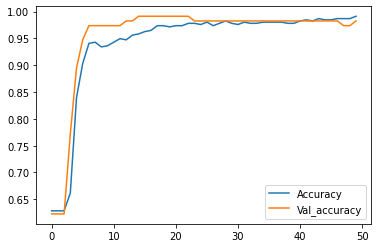

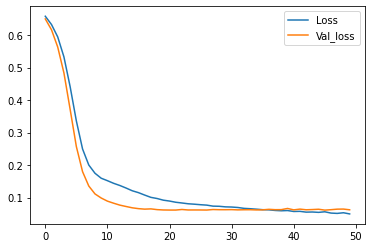

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Val_accuracy'])

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss'])

plt.show()

#Conclusions

The optimization of the pre-processing data gave me the possibility to develop a simple model, with few parameters (about 8000), but effective, with an excellent percentage of accuracy.

However, the dataset contains little data. Despite this, the model trains well and manages to find any patterns among the different features.

Finally, I thank Vincenzo Maritati (vincenzo.maritati@gmail.com) for the idea of ​​expanding the inputs of the model.